# Classification task

In [ ]:
# installation of packages
!pip install nltk

In [ ]:
# installation of NLTK data
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

## Data pre-processing

In [1]:
# Loading data
import ast
import pandas as pd

# reading the dataset 
df = pd.read_csv('../data/dataset_filtered_labels.csv')

# getting the list of genres 
genres = set()
for v in df['genres'].values: genres = set(list(genres) + ast.literal_eval(v))
genres = list(genres)

# creating the mappings from genres to id and vice versa
genre2id = {k:v for (v, k) in enumerate(genres)}
id2genre = {k:v for (k, v) in enumerate(genres)}

df.head()

,Unnamed: 0,wiki_id,frbs_id,name,author,date,genres,summary
0,0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"['humor', 'realistic fiction', ""children's lit...","Old Major, the old boar on the Manor Farm, cal..."
1,1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"['humor', 'science fiction']","Alex, a teenager living in near-future England..."
2,2,986,/m/0ldx,The Plague,Albert Camus,1947,['realistic fiction'],The text of The Plague is divided into five pa...
3,3,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"['science fiction', 'fantasy']",The novel posits that space around the Milky W...
4,4,2152,/m/0x5g,All Quiet on the Western Front,Erich Maria Remarque,1929-01-29,"['historical', 'realistic fiction']","The book tells the story of Paul Bäumer, a Ger..."


In [2]:
from sklearn.model_selection import train_test_split
import numpy as np

X = df['summary'].to_numpy() # corpus - predictor variables
Y = np.full((X.shape[0], len(genres)), 0, dtype=int) # genres - target variables

# populating Y

genre_data = df['genres'].to_numpy() # genres assigned to works
for idx in range(len(Y)):
    genre_data[idx] = ast.literal_eval(genre_data[idx])
    for g in genre_data[idx]: Y[idx][genre2id[g]] = 1


/home/vera/anaconda3/envs/data_literacy_project/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

# defining tokenizer which performs lemmatization and skips stop or/and non-alphabetic words
class LemmaTokenizer:
    def __init__(self):
        self.stops = set(stopwords.words('english'))
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t).lower() for t in word_tokenize(doc) if self.wnl.lemmatize(t) not in self.stops and t.isalpha()]
    
# defining TF-IDF vectorizer
# we put threshold of 1% for term presence in summaries so we can filter out the least common terms
# which can cause the overfitting of the classifier (this choice is backed by Zipf's law)
vectorizer = TfidfVectorizer(tokenizer=LemmaTokenizer(), min_df=0.01)

## Classifiers

In [10]:
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline

from sklearn.model_selection import RandomizedSearchCV, cross_validate, KFold

from sklearn.metrics import make_scorer, accuracy_score, hamming_loss

from datetime import datetime
from scipy.stats import randint
import pickle
import os

In [5]:
# report performance
def report_performance_on_test_sets(scores):
    import numpy as np
    
    print('F1 micro score: mean = %.3f, standard deviation = %.3f' %(np.mean(scores['test_F1 micro']), 
                                                                 np.std(scores['test_F1 micro'])))
    
    print('Accuracy: mean = %.3f, standard deviation = %.3f' %(np.mean(scores['test_Accuracy']), 
                                                                 np.std(scores['test_Accuracy'])))
    
    print('Hamming loss: mean = %.3f, standard deviation = %.3f' %(np.mean(scores['test_Hamming loss']), 
                                                                 np.std(scores['test_Hamming loss'])))
    


### Multinomial Naive Bayes

In [56]:
st=datetime.now() 

# defining the model and fitting
base_twcnb = ComplementNB()
clf_twcnb = OneVsRestClassifier(base_twcnb)

steps = list()
steps.append(('tfidf', TfidfVectorizer(tokenizer=LemmaTokenizer(), min_df=0.01)))
steps.append(('model', clf_twcnb))
pipeline = Pipeline(steps=steps)

cv = KFold(n_splits=5, shuffle=True, random_state=2023)

scoring = {"F1 micro": "f1_micro", "Accuracy": make_scorer(accuracy_score), 
           "Hamming loss": make_scorer(hamming_loss)}

mnb_scores = cross_validate(pipeline, X=X, y=Y, cv=cv, scoring = scoring, return_estimator = True)

print("Time taken to perform multiple model evaluation: ",datetime.now()-st)
report_performance_on_test_sets(mnb_scores)

KeyError: 'test_score'

In [20]:
cwd = os.getcwd()
print(cwd)

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!CHANGE ACCORDINGLY!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
os.chdir('/home/vera/Documents/master tue/data literacy/project/automatic-book-genre-classification')

/home/vera/Documents/master tue


In [23]:
with open('./data/MNB_scores.pkl', 'wb') as f:
    pickle.dump(mnb_scores, f)
        
#with open('./data/MNB_scores.pkl', 'rb') as f:
#    MNB_scores = pickle.load(f)

{'a': 2, 'b': 3}


### Logistic regression

In [27]:
def tune_and_evaluate_model(model, param_space, X, Y):
    
    # define the pipeline
    steps = list()
    steps.append(('tfidf', TfidfVectorizer(tokenizer=LemmaTokenizer(), min_df=0.01)))
    steps.append(('model', model))
    pipeline = Pipeline(steps=steps)

    inner_cv = KFold(n_splits=2, shuffle=True, random_state=2023) # for hyperparameter tuning
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=2023)

    #defining scoring for k fold cross validation
    scoring = {"F1 micro": "f1_micro", "Accuracy": make_scorer(accuracy_score), 
               "Hamming loss": make_scorer(hamming_loss)}

    # Nested CV with parameter optimization
    # for  hypoparameter tuning f1 score will be used to find the best parameters for refitting the 
    # estimator at the end. It is specified with the parameter refit = 'F1 micro'.
    clf = RandomizedSearchCV(pipeline, param_space, n_iter=3, scoring = scoring, cv = inner_cv, 
                             refit = 'F1 micro')
    
    scores = cross_validate(clf, X=X, y=Y, cv=outer_cv, return_estimator = True, scoring = scoring)

    # report performance
    report_performance_on_test_sets(scores)
    return scores

In [28]:
st=datetime.now() 

clf_lr = OneVsRestClassifier(LogisticRegression(max_iter = 200))
param_space = {
              'model__estimator__C':[0.01,0.1,1,5,10] 
              }
lr_scores = tune_and_evaluate_model(clf_lr, param_space, X, Y)

print("Time taken to perform hyperparameter tuning and multiple model evaluation: ",datetime.now()-st)

Time taken to perform hyperparameter tuning and multiple model evaluation:  0:24:20.546529
F1 micro score: mean = 0.525, standard deviation = 0.005
Accuracy: mean = 0.285, standard deviation = 0.006
Hamming loss: mean = 0.080, standard deviation = 0.001


In [29]:
with open('./data/LR_scores.pkl', 'wb') as g:
    pickle.dump(lr_scores, g)

In [30]:
# with open('./data/LR_scores.pkl', 'rb') as g:
#    lr_scores = pickle.load(g)

### Random forest classifier
Inherently supports mulitilabel classification

In [ ]:
st=datetime.now() 

rf = RandomForestClassifier(n_estimators = 2)

param_space = {
              'model__max_depth':list(np.arange(10, 250, step=50))
              }
rf_scores = tune_and_evaluate_model(rf, param_space, X, Y)
print("Time taken to perform hyperparameter tuning and multiple model evaluation: ",datetime.now()-st)


In [ ]:
with open('./data/RF_scores.pkl', 'wb') as h:
    pickle.dump(rf_scores, h)

In [ ]:
# with open('./data/RF_scores.pkl', 'rb') as h:
#    RF_scores = pickle.load(h)

### XGBoost

In [ ]:
# define the classifier
st=datetime.now() 

xgboost = xgb.XGBClassifier(objective = 'multi:softmax',                                  
                            seed = 2023,  
                            num_class=2,
                            gamma =  0.1,
                            learning_rate = 0.5,
                            n_estimators = 200
                            
                         ) 
one_vs_rest_xgboost = OneVsRestClassifier(xgboost)

param_space = {
              'model__estimator__max_depth':list(np.arange(3,5, step=1))
              }
xgboost_scores = tune_and_evaluate_model(one_vs_rest_xgboost, param_space, X, Y)
print("Time taken to perform hyperparameter tuning and multiple model evaluation: ",datetime.now()-st)


In [ ]:
with open('./data/XGBoost_scores.pkl', 'wb') as i:
    pickle.dump(xgboost_scores, i)

In [ ]:
# with open('./data/XGBoost_scores.pkl', 'rb') as i:
#    XGBoost_scores = pickle.load(i)

## Evaluation of the models 

Text(0.5, 1.0, "Models' performances")

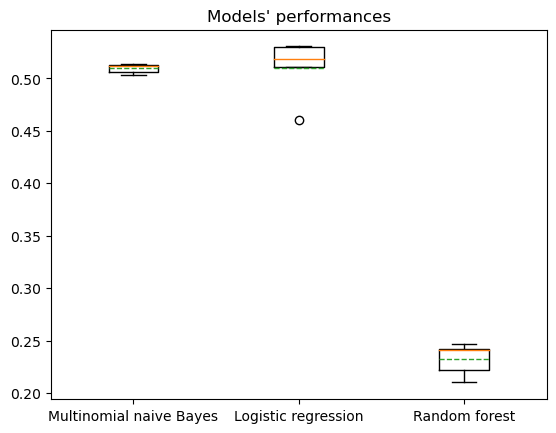

In [84]:
models_scores_f1 =  {'Multinomial naive Bayes': mnb_scores['test_F1 micro'], 
                     'Logistic regression': lr_scores['test_F1 micro'],
                     'Random forest': nrf_scores['test_F1 micro'],
                     'XGBoost' : xgboost_scores['test_F1 micro']
                    }

fig, ax = plt.subplots()
ax.boxplot(models_scores_f1.values(), showmeans=True, meanline = True)
ax.set_xticklabels(models_scores_f1.keys())
ax.set_xlabel("Model")
ax.set_ylabel("F1 (micro) score")

In [ ]:
models_scores_accuracy = {'Multinomial naive Bayes': mnb_scores['test_Accuracy'], 
                 'Logistic regression': lr_scores['test_Accuracy'],
                 'Random forest': nrf_scores['test_Accuracy'],
                 'XGBoost' : xgboost_scores['test_Accuracy']
                }

fig, ax = plt.subplots()
ax.boxplot(models_scores_accuracy.values(), showmeans=True, meanline = True)
ax.set_xticklabels(models_scores_accuracy.keys())
ax.set_xlabel("Model")
ax.set_ylabel("Accuracy")

In [ ]:
models_scores_hamming = {'Multinomial naive Bayes': mnb_scores['test_Hamming loss'], 
                         'Logistic regression': lr_scores['test_Hamming loss'],
                         'Random forest': nrf_scores['test_Hamming loss'],
                         'XGBoost' : xgboost_scores['test_Hamming loss']
                        }

fig, ax = plt.subplots()
ax.boxplot(models_scores_hamming.values(), showmeans=True, meanline = True)
ax.set_xticklabels(models_scores_hamming.keys())
ax.set_xlabel("Model")
ax.set_ylabel("Hamming loss")